# 0. Imports and functions definitions

In [1]:
import uproot
import numpy             as np
import matplotlib.pyplot as plt

from __init__ import *

### Define your variables

In [2]:
folder    = "/pc/choozdsk01/palomare/GEANT4/megacell_v3/"
sensors   = ["Arapuca","SiPM1","SiPM2"]
contenido = ["megacell_v3_t0.root"]
debug     = True

In [3]:
all_data = []
for my_file in contenido: all_data.append(extract_branches(folder=folder,root_file=my_file,sensors=sensors,debug=debug))

{'megacell_v3_t0.root': {'Arapuca': {'X': array([ -3.58096449,  22.95833526, -22.81904209, ...,  43.11413365,
       -16.45285317,  25.53514048]), 'Y': array([0.51, 0.51, 0.51, ..., 0.51, 0.51, 0.51]), 'Z': array([ 36.43139184, -18.12000009, -20.57213815, ...,   9.02062616,
        35.87695863,  46.94709546]), 'Phi': array([-1.55654928, -1.21276956, -1.81261265, ..., -0.98595867,
       -1.71547122, -1.17001617]), 'Theta': array([1.04240294, 1.7158412 , 1.7524792 , ..., 1.44631576, 1.10005484,
       1.02178416]), 'Sensor': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0

### DEFINE YOUR GEOMETRY
* Unitary vectors
* Sensors dimensions

In [4]:
# Add unitary vectors
sensors_info=dict(); #area and unitary vectors for each configuration file
for sensor in sensors:
    sensors_info[sensor]={}
    for my_file in contenido:
        sensors_info[sensor][my_file]={}
        if (sensor=="Arapuca"): sensors_info[sensor][my_file]=np.array([ 0, 1, 0])
        if (sensor=="SiPM1"):   sensors_info[sensor][my_file]=np.array([ 1, 0, 0])
        if (sensor=="SiPM2"):   sensors_info[sensor][my_file]=np.array([-1, 0, 0])

sensors_info["Arapuca"]["Area"] = 143.75*143.75 #mm**2
sensors_info["SiPM1"]["Area"]   = 6*6           #mm**2
sensors_info["SiPM2"]["Area"]   = 6*6           #mm**2


for d,data in enumerate(all_data): compute_real_angles(my_data=data,sensors_info=sensors_info,debug=debug)

{'Arapuca': {'megacell_v3_t0.root': array([0, 1, 0]), 'Area': 20664.0625}, 'SiPM1': {'megacell_v3_t0.root': array([1, 0, 0]), 'Area': 36}, 'SiPM2': {'megacell_v3_t0.root': array([-1,  0,  0]), 'Area': 36}}


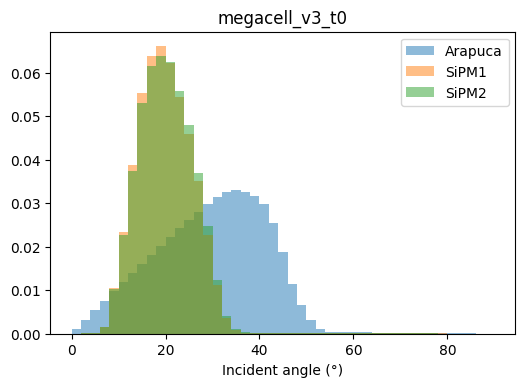

In [5]:
for d,my_data in enumerate(all_data): fig_ang = plot_angular_distributions(my_data,dpi=100)

<Figure size 600x400 with 0 Axes>

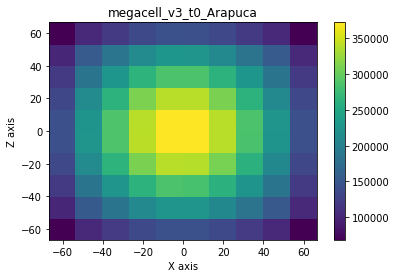

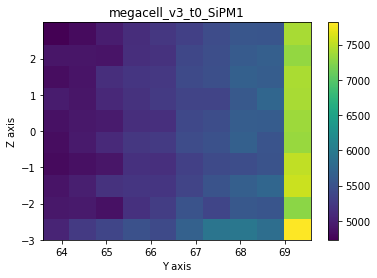

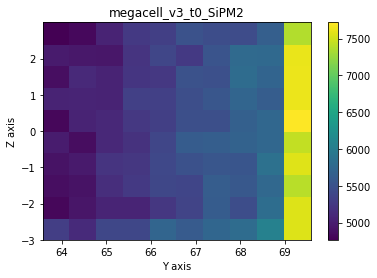

In [6]:
for d,my_data in enumerate(all_data): fig_ph = plot_photon_density(my_data,sensors_info,dpi=100)

/afs/ciemat.es/user/m/manthey/Code/SIM_LAB_GEANT4/analysis/__init__.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


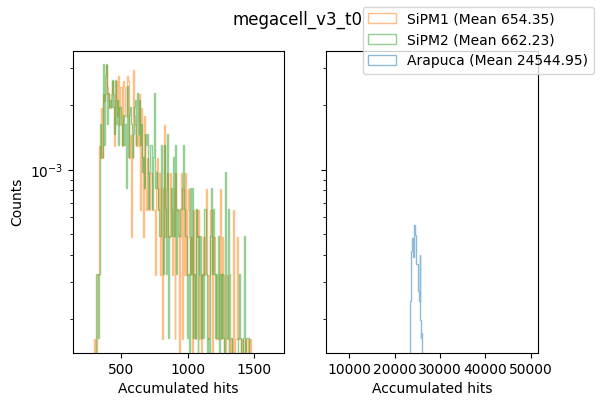

In [7]:
for d,my_data in enumerate(all_data): fig_acum = plot_acumhits(my_data,dpi=100,semilogy=True,bins=[200,200,200])